# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_save_file`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**,
- please also submit the file that contains your trained model.
    - use `saveModel` to put your final, trained model in this file
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the name of the file in which the model was saved
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


In [1]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from tensorflow.keras import layers, models
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import requests
import seaborn as sns

# Recipe step A: Get the data

## Recipe A.1: Get the data

**Note:View adj_close as target value instead of close value,because adj_close aviods the effect of Some events,such as stock splits, dividends, on stock price.**

In [2]:
DATA_DIR = './Data/train/'
filename = 'AAPL'

def get_data(DATA_DIR, filename= 'AAPL', log=False):
    data = pd.read_csv(DATA_DIR + filename + '.csv')
    df = data.copy()
    df['Return'] = df['Adj Close'].pct_change().copy()
    return df
df= get_data(DATA_DIR, filename)
df_adbe = get_data(DATA_DIR, 'ADBE')
df_intc = get_data(DATA_DIR, "INTC")
df_xlk = get_data(DATA_DIR, "XLK")
df_spy = get_data(DATA_DIR, "SPY")
df_csco = get_data(DATA_DIR, "CSCO")

## Recipe A.2: Have a look at data

In [3]:
df.info()
df_adbe.info()
df_intc.info()
df_xlk.info()
df_spy.info()
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor     4277 non-null   float64
 5   High       4277 non-null   float64
 6   Low        4277 non-null   float64
 7   Open       4277 non-null   float64
 8   Volume     4277 non-null   float64
 9   Return     4276 non-null   float64
dtypes: float64(9), object(1)
memory usage: 334.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dt         4277 non-null   object 
 1   Adj Close  4277 non-null   float64
 2   Close      4277 non-null   float64
 3   Div        4277 non-null   float64
 4   Factor 

**Note that the first conlumn of data is calendar objec which cannot be used in machine learning model**

In [4]:
df.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03,4276.000000
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08,0.001186
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07,0.026760
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.518677
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07,-0.011262
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08,0.000806
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08,0.013808
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,0.139042


In [5]:
df.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390


# Recipe step B: Exploatory Data Analysis

## Recipe B1: the target value ( return ) distribution

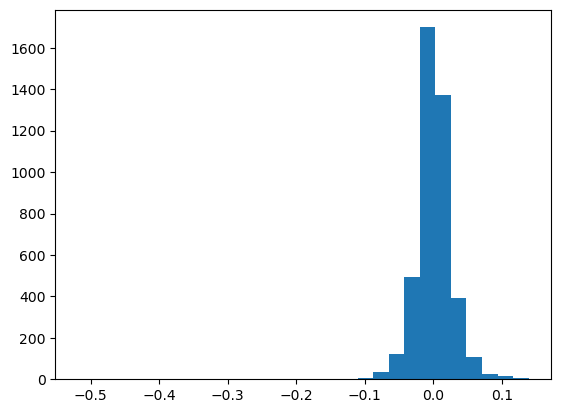

There are 47.81388823942015% returns less than 0 and 51.53144727612813% returns above 0


In [6]:
y = df.iloc[:,-1]
bin_edges = np.linspace(y.min(), y.max(), 30)
plt.hist(y, bins=bin_edges)
plt.show()
y_negative= sum(y<0)/len(y)*100
y_pos= sum(y>0)/len(y)*100
print('There are {n1}% returns less than 0 and {n2}% returns above 0'.format(n1=y_negative,n2=y_pos))

**There is a problem called data imbalance.According to data imbalance analysis, the amount of return far away from 0 is less than the amout of return close to 0.what we shall do is to use loss sensitive training and data augomentation or try to find a model cannot be affected by data imbalanced.**

## Recipe B2: Correlation Matrix

D:\temp\ipykernel_20008\589634376.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X.corr()


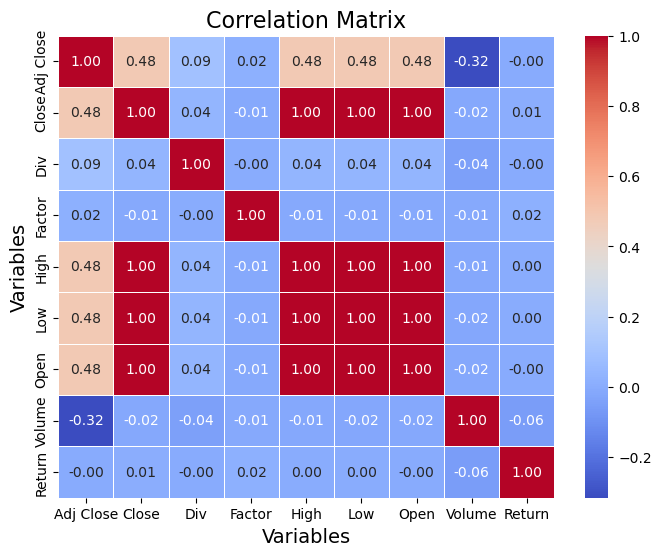

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
X = df.iloc[:,0:10]
correlation_matrix = X.corr()
threshold = 0.5
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.show()

**As we can see, the correlation amoung target value(return) and other features(close,factor,high and so on) is extremely slight.Therefore, those feature cannot be used to predict the future return and we shall create some synthetic features.**

## Recipe B3: Density Distribution Diagram

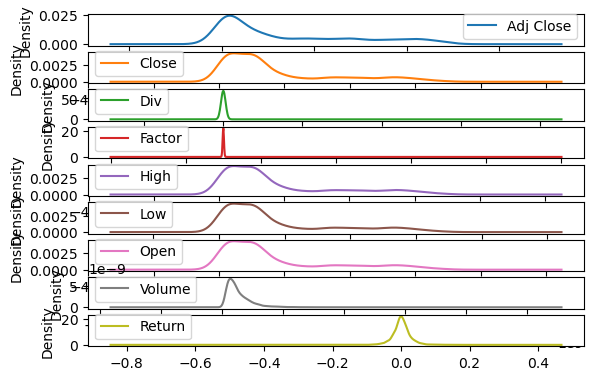

In [8]:
df.plot(kind='density', subplots=True, layout=(len(df.columns),1), sharex=False)
plt.show()

## Recipe B4: Autocorrelation function test (ACF) of return

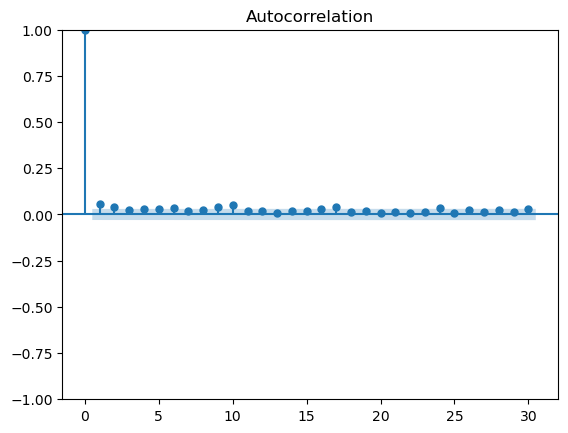

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(np.square(y[1:len(y)]), lags=30)  # Set the number of lags to 30
plt.show()

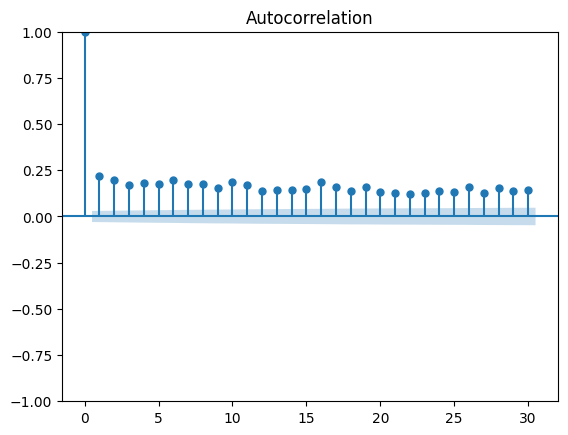

In [10]:
sm.graphics.tsa.plot_acf(np.abs(y[1:len(y)]), lags=30)  # Set the number of lags to 30
plt.show()

**The phenomenon I described is called "volatility clustering." In financial time series, it refers to the persistence of volatility, where periods of high or low volatility tend to cluster together over time. Specifically, when the autocorrelation coefficients between returns are not significant, but the autocorrelation coefficients between the absolute values of returns are significant, it is referred to as volatility clustering.**

# Recipe step C: Prepare the data

## Recipe C1: Feature Engineering

**feature1: absolute value of return**

In [11]:
def absolutes(date):
    dd  = np.abs(date)
    return dd

**feature2: MACD**

In [12]:
def cal_macd(close):
    short_ema = close.ewm(span=12, adjust=False).mean()
    long_ema = close.ewm(span=26, adjust=False).mean()

    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=9, adjust=False).mean()

    return signal_line

**feature3: Relative Strength Index**

In [13]:
def cal_rsi(close, window=14):
    price_diff = close.diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

**feature4: Spread**

In [14]:
def spread(data):
    data['range'] = data['High'] - data['Low']
    return data

In [15]:
def cal_technical_indicators(stock):
    stock['abs'] = absolutes(stock['Return'])
    stock['macd']= cal_macd(stock['Adj Close'])
    stock['rsi'] = cal_rsi(stock['Adj Close'])
    spread(stock)
    return stock

In [16]:
df = cal_technical_indicators(df)
df_adbe = cal_technical_indicators(df_adbe)
df_intc = cal_technical_indicators(df_intc)
df_xlk = cal_technical_indicators(df_xlk)
df_spy = cal_technical_indicators(df_spy)
df_csco = cal_technical_indicators(df_csco)
df.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN,NaN,0.000000,NaN,10.812
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,0.084318,-0.004679,0.000000,9.437
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,0.014630,-0.011292,13.709915,7.563
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,0.086546,-0.023207,7.520981,12.000
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,0.047390,-0.035536,24.555629,5.500


In [17]:

df_adbe.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,16.2747,65.563,0.0,1.0,67.500,64.250,67.2500,7384400.0,NaN,NaN,0.000000,NaN,3.250
1,2000-01-04,14.9094,60.063,0.0,1.0,65.813,59.938,63.0000,7813200.0,-0.083891,0.083891,-0.021783,0.000000,5.875
2,2000-01-05,15.2042,61.250,0.0,1.0,62.750,58.250,58.2500,14927200.0,0.019773,0.019773,-0.051323,17.757966,4.500
3,2000-01-06,15.3283,61.750,0.0,1.0,62.625,60.625,61.4393,10221200.0,0.008162,0.008162,-0.082081,23.478310,2.000
4,2000-01-07,16.0730,64.750,0.0,1.0,64.750,60.875,61.5630,8253200.0,0.048583,0.048583,-0.099921,46.012100,3.875


In [18]:
df_intc.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,28.0137,43.500,0.0,1.0,43.6880,41.625,41.633,57710200.0,NaN,NaN,0.000000,NaN,2.0630
1,2000-01-04,26.7056,41.469,0.0,1.0,43.9380,41.125,42.719,51019600.0,-0.046695,0.046695,-0.020870,0.000000,2.8130
2,2000-01-05,26.9270,41.813,0.0,1.0,42.9345,40.250,41.500,52389000.0,0.008290,0.008290,-0.050147,14.475319,2.6845
3,2000-01-06,25.3572,39.375,0.0,1.0,41.6880,39.094,40.875,55171200.0,-0.058298,0.058298,-0.108089,7.143549,2.5940
4,2000-01-07,26.4037,41.000,0.0,1.0,41.0000,38.688,38.750,41096400.0,0.041270,0.041270,-0.164019,30.582758,2.3120


In [19]:

df_xlk.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,43.6306,55.438,0.0,1.0,55.625,53.5000,55.625,938100.0,NaN,NaN,0.000000,NaN,2.1250
1,2000-01-04,41.4171,52.625,0.0,1.0,54.750,52.3130,54.000,545500.0,-0.050733,0.050733,-0.035315,0.000000,2.4370
2,2000-01-05,40.8022,51.844,0.0,1.0,53.063,50.1250,51.750,1906000.0,-0.014847,0.014847,-0.100644,0.000000,2.9380
3,2000-01-06,39.4496,50.125,0.0,1.0,52.094,49.6250,51.250,1670000.0,-0.033150,0.033150,-0.202710,0.000000,2.4690
4,2000-01-07,40.1382,51.000,0.0,1.0,51.000,49.1263,49.625,686000.0,0.017455,0.017455,-0.311004,14.140792,1.8737


In [20]:

df_xlk.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,43.6306,55.438,0.0,1.0,55.625,53.5000,55.625,938100.0,NaN,NaN,0.000000,NaN,2.1250
1,2000-01-04,41.4171,52.625,0.0,1.0,54.750,52.3130,54.000,545500.0,-0.050733,0.050733,-0.035315,0.000000,2.4370
2,2000-01-05,40.8022,51.844,0.0,1.0,53.063,50.1250,51.750,1906000.0,-0.014847,0.014847,-0.100644,0.000000,2.9380
3,2000-01-06,39.4496,50.125,0.0,1.0,52.094,49.6250,51.250,1670000.0,-0.033150,0.033150,-0.202710,0.000000,2.4690
4,2000-01-07,40.1382,51.000,0.0,1.0,51.000,49.1263,49.625,686000.0,0.017455,0.017455,-0.311004,14.140792,1.8737


In [21]:

df_csco.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
0,2000-01-03,42.1339,108.063,0.0,1.0,110.250,103.563,109.9380,53076000.0,NaN,NaN,0.000000,NaN,6.687
1,2000-01-04,39.7701,102.000,0.0,1.0,107.000,101.750,105.5000,50805600.0,-0.056102,0.056102,-0.037713,0.000000,5.250
2,2000-01-05,39.6482,101.688,0.0,1.0,104.500,97.250,100.0630,68524000.0,-0.003065,0.003065,-0.098946,0.000000,7.250
3,2000-01-06,38.9903,100.000,0.0,1.0,101.875,98.625,100.8130,48242600.0,-0.016593,0.016593,-0.181981,0.000000,3.250
4,2000-01-07,41.2810,105.875,0.0,1.0,106.000,99.375,99.3751,62260600.0,0.058751,0.058751,-0.237368,42.152623,6.625


## Recipe C2: Cleaning

In [22]:
def cleaning(X):
    df2 = X.dropna()
    return df2


df = cleaning(df)
a= df.isnull().sum().sum()
print("There are {a1} null values in feature matrix".format(a1=a))
df.head()

There are 0 null values in feature matrix


,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,abs,macd,rsi,range
1,2000-01-04,3.1852,102.50,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,0.084318,-0.004679,0.000000,9.437
2,2000-01-05,3.2318,104.00,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,0.014630,-0.011292,13.709915,7.563
3,2000-01-06,2.9521,95.00,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,0.086546,-0.023207,7.520981,12.000
4,2000-01-07,3.0920,99.50,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,0.047390,-0.035536,24.555629,5.500
5,2000-01-10,3.0376,97.75,0.0,1.0,102.250,94.750,102.0000,126266000.0,-0.017594,0.017594,-0.048264,22.914363,7.500


In [23]:
df_adbe = cleaning(df_adbe)
df_intc = cleaning(df_intc)
df_xlk = cleaning(df_xlk)
df_spy = cleaning(df_spy)
df_csco = cleaning(df_csco)

## Recipe C3: eliminate ineffective feature

In [24]:
def eliminate_feature(arr):
    df=arr.iloc[:,[0,8,9,10,11,12,13]]
    return df
#df = eliminate_feature(df)
df.head

<bound method NDFrame.head of               Dt  Adj Close   Close  Div  Factor      High      Low      Open  \
1     2000-01-04     3.1852  102.50  0.0     1.0  110.6250  101.188  108.2500   
2     2000-01-05     3.2318  104.00  0.0     1.0  110.5630  103.000  103.7500   
3     2000-01-06     2.9521   95.00  0.0     1.0  107.0000   95.000  106.1183   
4     2000-01-07     3.0920   99.50  0.0     1.0  101.0000   95.500   96.5000   
5     2000-01-10     3.0376   97.75  0.0     1.0  102.2500   94.750  102.0000   
...          ...        ...     ...  ...     ...       ...      ...       ...   
4272  2016-12-23   111.3073  116.52  0.0     1.0  116.5255  115.590  115.5900   
4273  2016-12-27   112.0142  117.26  0.0     1.0  117.8000  116.490  116.5200   
4274  2016-12-28   111.5366  116.76  0.0     1.0  118.0170  116.200  117.5200   
4275  2016-12-29   111.5079  116.73  0.0     1.0  117.1094  116.400  116.4500   
4276  2016-12-30   110.6386  115.82  0.0     1.0  117.2000  115.430  116.6577   

           Volume    Return       abs      macd        rsi    range  
1     128094400.0 -0.084318  0.084318 -0.004679   0.000000   9.4370  
2     194580400.0  0.014630  0.014630 -0.011292  13.709915   7.5630  
3     191993200.0 -0.086546  0.086546 -0.023207   7.520981  12.0000  
4     115183600.0  0.047390  0.047390 -0.035536  24.555629   5.5000  
5     126266000.0 -0.017594  0.017594 -0.048264  22.914363   7.5000  
...           ...       ...       ...       ...        ...      ...  
4272   14249500.0  0.001978  0.001978  1.075025  86.146147   0.9355  
4273   18296900.0  0.006351  0.006351  1.159081  86.009695   1.3100  
4274   20905900.0 -0.004264  0.004264  1.222026  79.937431   1.8170  
4275   15039500.0 -0.000257  0.000257  1.265195  77.085358   0.7094  
4276   30586300.0 -0.007796  0.007796  1.276954  62.318461   1.7700  

[4276 rows x 14 columns]>

In [25]:
df_adbe = eliminate_feature(df_adbe)
df_intc = eliminate_feature(df_intc)
df_xlk = eliminate_feature(df_xlk)
df_spy = eliminate_feature(df_spy)
df_csco = eliminate_feature(df_csco)


## Recipe C4:  merge data

In [26]:
df_1= pd.concat([df,df_adbe.iloc[:,[2,3]],df_intc.iloc[:,[2,3]],df_xlk.iloc[:,[2,3]],df_spy.iloc[:,[2,3]],df_csco.iloc[:,[2,3]] ], axis=1)
df_1.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,...,Return,abs,Return,abs,Return,abs,Return,abs,Return,abs
1,2000-01-04,3.1852,102.50,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,...,-0.083891,0.083891,-0.046695,0.046695,-0.050733,0.050733,-0.039106,0.039106,-0.056102,0.056102
2,2000-01-05,3.2318,104.00,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,...,0.019773,0.019773,0.008290,0.008290,-0.014847,0.014847,0.001789,0.001789,-0.003065,0.003065
3,2000-01-06,2.9521,95.00,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,...,0.008162,0.008162,-0.058298,0.058298,-0.033150,0.033150,-0.016071,0.016071,-0.016593,0.016593
4,2000-01-07,3.0920,99.50,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,...,0.048583,0.048583,0.041270,0.041270,0.017455,0.017455,0.058076,0.058076,0.058751,0.058751
5,2000-01-10,3.0376,97.75,0.0,1.0,102.250,94.750,102.0000,126266000.0,-0.017594,...,0.038611,0.038611,0.045732,0.045732,0.037991,0.037991,0.003430,0.003430,0.037189,0.037189


In [27]:
df_1.shape[0]

4276

## Recipe C5: split data

- **splits df into regression data(df_regress) and classification data(df_classification)**
- **split df_reg_X,df_reg_y,df_cla_X,df_cla_y into train set and test set**

In [28]:
def split_data(df_1,ratio=0.8):
    df_regress = df_1.iloc[:,[9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
    df_class = df_1.iloc[:,[9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
    num_rows_80_percent = int(len(df_regress) * ratio)
    df_regress_train = df_regress.iloc[0:num_rows_80_percent,:]
    df_regress_test = df_regress.iloc[num_rows_80_percent:len(df_regress),:]
    df_class_train = df_class.iloc[0:num_rows_80_percent,:]
    df_class_test = df_class.iloc[num_rows_80_percent:len(df_regress),:]
    return df_regress_train,df_regress_test,df_class_train,df_class_test
df_regress_trains,df_regress_tests,df_class_trains,df_class_tests = split_data(df_1)

scaler = StandardScaler()
df_regress_train = scaler.fit_transform(df_regress_trains)
df_regress_train = pd.DataFrame(df_regress_train, columns=df_regress_trains.columns)
df_class_train = scaler.fit_transform(df_class_trains)
df_class_train = pd.DataFrame(df_class_train, columns=df_class_trains.columns)
df_regress_test = scaler.fit_transform(df_regress_tests)
df_regress_test = pd.DataFrame(df_regress_test, columns=df_regress_tests.columns)
df_class_test = scaler.fit_transform(df_class_tests)
df_class_test = pd.DataFrame(df_class_test, columns=df_class_tests.columns)

In [29]:
df_class_train.head()

,Return,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,...,Return,abs,Return,abs,Return,abs,Return,abs,Return,abs
0,-2.957113,-0.726659,-0.338400,-0.038171,-0.02419,-0.299589,-0.336981,-0.304746,-0.200540,-2.957113,...,-2.729145,2.723748,-1.807147,1.532312,-2.839447,2.947681,-2.940200,3.040809,-2.024222,1.809532
1,0.461632,-0.724517,-0.329541,-0.038171,-0.02419,-0.299951,-0.326176,-0.331293,0.448979,0.461632,...,0.611513,-0.034243,0.310810,-0.514543,-0.832493,0.202425,0.118330,-0.726133,-0.117002,-0.739331
2,-3.034101,-0.737374,-0.382695,-0.038171,-0.02419,-0.320800,-0.373881,-0.317322,0.423704,-3.034101,...,0.237352,-0.533661,-2.254091,2.150737,-1.856133,1.602633,-1.217415,0.715569,-0.603483,-0.089184
3,1.593513,-0.730943,-0.356118,-0.038171,-0.02419,-0.355908,-0.370900,-0.374062,-0.326670,1.593513,...,1.539960,1.205020,1.581149,1.243192,0.973996,0.401984,4.328045,4.955710,2.105900,1.936810
4,-0.651734,-0.733444,-0.366453,-0.038171,-0.02419,-0.348594,-0.375372,-0.341616,-0.218403,-0.651734,...,1.218603,0.776083,1.753014,1.480999,2.122484,1.972970,0.241105,-0.560425,1.330545,0.900603


## Recipe C6: prepare data

- **splits df_regress and df_classification into df_reg_X,df_reg_y,df_cla_X,df_cla_y**

In [30]:
def data_prep(train_data,window_size = 20,types='regress'):
    if types=='regress':
        x_train = []
        y_train = []
        for i in range(0, len(train_data) - window_size, 1):
            x_train.append(np.array(train_data.iloc[i:i+ window_size,:]))
            y_train.append(train_data.iloc[i + window_size,0])
        x_train = np.array(x_train)
        y_train = np.array(y_train)
    if types=='class':
        x_train = []
        y_train = []
        for i in range(0, len(train_data) - window_size, 1):
            x_train.append(np.array(train_data.iloc[i:i + window_size,:]))
            y_train.append(np.array(train_data.iloc[i + window_size, 0]>0))
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_train[:,:,0]=x_train[:,:,0]>0

    return x_train,y_train

In [31]:
df_class_train_X,df_class_train_y = data_prep(df_class_train,20,'class')
print(df_class_train_X.shape)
print(df_class_train_y.shape)

(3400, 20, 24)
(3400,)


In [32]:
df_regress_train_X,df_regress_train_y = data_prep(df_regress_train,20,'regress')
print(df_regress_train_X.shape)
print(df_regress_train_y.shape)

(3400, 20, 24)
(3400,)


In [33]:
df_class_test_X,df_class_test_y = data_prep(df_class_test,20,'class')
print(df_class_test_X.shape)
print(df_class_test_y.shape)

(836, 20, 24)
(836,)


In [34]:
df_regress_test_X,df_regress_test_y = data_prep(df_regress_test,20,'regress')
print(df_regress_test_X.shape)
print(df_regress_test_y.shape)

(836, 20, 24)
(836,)


# Recipe step D: Train a model

### The autocorrelation coefficients between returns are not significant, but the autocorrelation coefficients between the absolute values of returns are significant. Therefore, it is simple to use historical absolute returns to predict future absolute return. I come up with a good idea to predict future returns. I split prediction task into two parts. The first part is to predict absolute returns by LSTM regression model,and the other one is to predict the sign of each return by LSTM classification model.

## Recipe D1: classification model

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_class = Sequential([
    LSTM(128, input_shape=(20,24),return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histroy_class=model_class.fit(df_class_train_X, df_class_train_y, epochs=10, batch_size=32, validation_data=(df_class_test_X, df_class_test_y),shuffle=False)
model_class.summary()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


107/107 [==============================] - 16s 104ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/10
107/107 [==============================] - 5s 46ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/10
107/107 [==============================] - 6s 59ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/10
107/107 [==============================] - 5s 46ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/10
107/107 [==============================] - 5s 51ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/10
107/107 [==============================] - 5s 49ms/step - loss: 0.0000e+00 - accuracy: 0.5088 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 7/10
107/107 [==============================] - 5s 47ms/step - loss: 0.0000e+00 - accuracy: 0.508

In [36]:
score0 = model_class.evaluate(df_class_test_X,df_class_test_y)
model_name0='classification model'
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

27/27 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.5000
classification model: Test loss: 0.00 / Test accuracy: 0.50


## Recipe D2: Error analysis of classification model

**The performance of LSTM classification model is not good, so I have to find another way to classify the sign of  future returns. There are two reasonable ways to improve my classification model.**
- The first one is to use other method,such as KNN, dicision tree.
- The second one is to find more useful synthetic features.

### corrrelation between the return's sign and other features

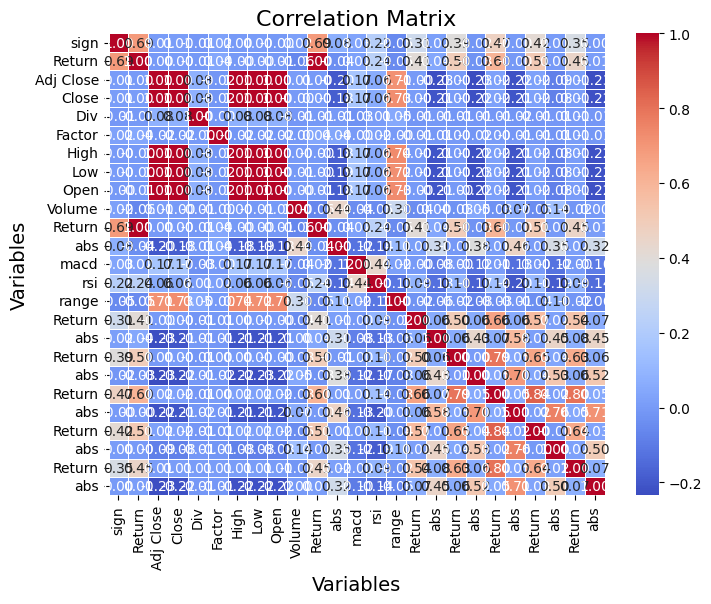

In [37]:
X = pd.concat([df_class_train.iloc[:,0]>0,df_class_train],axis=1)
columns = list(X.columns)
columns[0] = 'sign'
X.columns = columns
correlation_matrix = X.corr()
threshold = 0.5
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.show()

### autocorrrelation of the return's sign

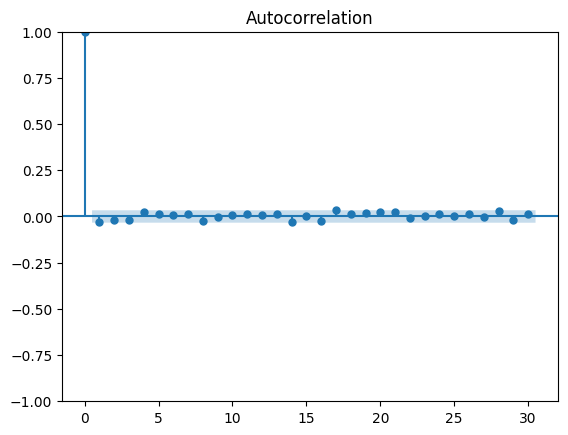

In [38]:
sm.graphics.tsa.plot_acf(df_class_train.iloc[:,0]>0, lags=30)  # Set the number of lags to 30
plt.show()

### I tried various features, including adding returns from many indices as features, but the accuracy of the classification model did not improve. Many indicators showed no obvious correlation with the sign of returns. Autocorrelation analysis of return signs also indicated no significant autocorrelation in the sequence of return signs. It's possible that the data lacks effective information, making it difficult to predict the sign of returns individually. Ultimately, I decided to abandon the classification model and consider using a regression model to predict stock returns.

## Recipe D3: regression model

In [39]:
model_regress = models.Sequential([
    layers.LSTM(50, return_sequences=True,input_shape=(20, 24)),
    layers.Dropout(0.2),
    layers.LSTM(25, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(10, ),
    layers.Dropout(0.2),
    layers.Dense(5),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_regress.compile(optimizer='adam', loss='mse')
history_regress = model_regress.fit(df_regress_train_X, df_regress_train_y, validation_data=(df_regress_test_X, df_regress_test_y), epochs=20, batch_size=10, shuffle=False)

model_regress.summary()

Epoch 1/20
340/340 [==============================] - 11s 19ms/step - loss: 1.0123 - val_loss: 1.0009
Epoch 2/20
340/340 [==============================] - 6s 19ms/step - loss: 0.9899 - val_loss: 1.0020
Epoch 3/20
340/340 [==============================] - 5s 16ms/step - loss: 0.9866 - val_loss: 1.0039
Epoch 4/20
340/340 [==============================] - 7s 19ms/step - loss: 0.9744 - val_loss: 1.0099
Epoch 5/20
340/340 [==============================] - 5s 16ms/step - loss: 0.9808 - val_loss: 1.0051
Epoch 6/20
340/340 [==============================] - 7s 20ms/step - loss: 0.9766 - val_loss: 1.0095
Epoch 7/20
340/340 [==============================] - 6s 19ms/step - loss: 0.9677 - val_loss: 1.0099
Epoch 8/20
340/340 [==============================] - 7s 19ms/step - loss: 0.9541 - val_loss: 1.0170
Epoch 9/20
340/340 [==============================] - 7s 19ms/step - loss: 0.9661 - val_loss: 0.9876
Epoch 10/20
340/340 [==============================] - 5s 16ms/step - loss: 0.9475 - val_l

## Recipe D4: Error analysis of regression model

In [40]:
test_predict = model_regress.predict(df_regress_test_X)
test_rmse = np.sqrt(mean_squared_error(df_regress_test_y,test_predict))
print(f'Test RMSE: {test_rmse}')


27/27 [==============================] - 2s 11ms/step
Test RMSE: 1.094021984306925


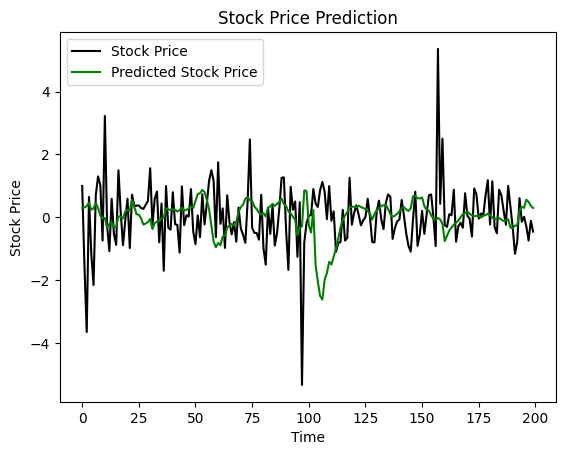

In [41]:
plt.plot(df_regress_test_y[0:200], color='black', label='Stock Price')
plt.plot(test_predict[0:200], color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### I attempt to add new trend indicators such as moving average lines, MACD and so on  and construct a new LSTM regression model

## Recipe D5: a new regression model

In [51]:
model_regress_ad = models.Sequential([
    layers.LSTM(50, return_sequences=True,input_shape=(20, 24)),
    layers.Dropout(0.2),
    layers.LSTM(25, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(10, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(10, ),
    layers.Dropout(0.2),
    layers.Dense(5),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_regress_ad.compile(optimizer='adam', loss='mse')
history_regress_ad = model_regress_ad.fit(df_regress_train_X, df_regress_train_y, validation_data=(df_regress_test_X, df_regress_test_y), epochs=40, batch_size=10, shuffle=False)

model_regress_ad.summary()

Epoch 1/40
340/340 [==============================] - 22s 45ms/step - loss: 0.9990 - val_loss: 1.0004
Epoch 2/40
340/340 [==============================] - 9s 25ms/step - loss: 0.9957 - val_loss: 1.0015
Epoch 3/40
340/340 [==============================] - 8s 25ms/step - loss: 0.9928 - val_loss: 1.0009
Epoch 4/40
340/340 [==============================] - 10s 28ms/step - loss: 0.9889 - val_loss: 1.0003
Epoch 5/40
340/340 [==============================] - 7s 22ms/step - loss: 0.9852 - val_loss: 1.0055
Epoch 6/40
340/340 [==============================] - 8s 25ms/step - loss: 0.9860 - val_loss: 1.0039
Epoch 7/40
340/340 [==============================] - 7s 22ms/step - loss: 0.9835 - val_loss: 1.0048
Epoch 8/40
340/340 [==============================] - 9s 26ms/step - loss: 0.9821 - val_loss: 0.9992
Epoch 9/40
340/340 [==============================] - 8s 25ms/step - loss: 0.9779 - val_loss: 1.0091
Epoch 10/40
340/340 [==============================] - 7s 22ms/step - loss: 0.9769 - val_

In [52]:
test_predict = model_regress_ad.predict(df_regress_test_X)
test_rmse = np.sqrt(mean_squared_error(df_regress_test_y,test_predict))
print(f'Test RMSE: {test_rmse}')

27/27 [==============================] - 2s 12ms/step
Test RMSE: 1.2241722194829165


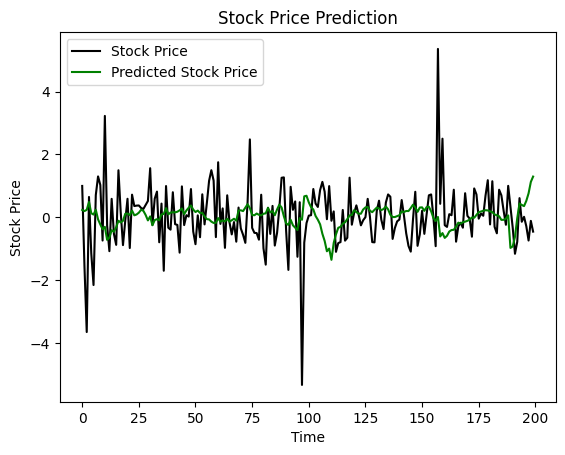

In [53]:
plt.plot(df_regress_test_y[0:200], color='black', label='Stock Price')
plt.plot(test_predict[0:200], color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# END

In [54]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from tensorflow.keras import layers, models
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import requests
import seaborn as sns

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path):
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))

    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))


def loadModel(model_save_file):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))

    return model

def MyModel(test_dir, model_save_file):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_save_file)
    DATA_DIR = test_dir
    filename = 'AAPL'

    def get_data(DATA_DIR, filename= 'AAPL', log=False):
        data = pd.read_csv(DATA_DIR + filename + '.csv')
        df = data.copy()
        df['Return'] = df['Adj Close'].pct_change().copy()
        return df
    df= get_data(DATA_DIR, filename)
    df_adbe = get_data(DATA_DIR, 'ADBE')
    df_intc = get_data(DATA_DIR, "INTC")
    df_xlk = get_data(DATA_DIR, "XLK")
    df_spy = get_data(DATA_DIR, "SPY")
    df_csco = get_data(DATA_DIR, "CSCO")
    def absolutes(date):
        dd  = np.abs(date)
        return dd
    def cal_macd(close):
        short_ema = close.ewm(span=12, adjust=False).mean()
        long_ema = close.ewm(span=26, adjust=False).mean()
        macd_line = short_ema - long_ema
        signal_line = macd_line.ewm(span=9, adjust=False).mean()
        return signal_line
    def cal_rsi(close, window=14):
        price_diff = close.diff(1)
        gain = price_diff.where(price_diff > 0, 0)
        loss = -price_diff.where(price_diff < 0, 0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    def spread(data):
        data['range'] = data['High'] - data['Low']
        return data
    def cal_technical_indicators(stock):
        stock['abs'] = absolutes(stock['Return'])
        stock['macd']= cal_macd(stock['Adj Close'])
        stock['rsi'] = cal_rsi(stock['Adj Close'])
        spread(stock)
        return stock
    df = cal_technical_indicators(df)
    df_adbe = cal_technical_indicators(df_adbe)
    df_intc = cal_technical_indicators(df_intc)
    df_xlk = cal_technical_indicators(df_xlk)
    df_spy = cal_technical_indicators(df_spy)
    df_csco = cal_technical_indicators(df_csco)
    def cleaning(X):
        df2=X.dropna()
        return df2
    df = cleaning(df)
    df_adbe = cleaning(df_adbe)
    df_intc = cleaning(df_intc)
    df_xlk = cleaning(df_xlk)
    df_spy = cleaning(df_spy)
    df_csco = cleaning(df_csco)
    def eliminate_feature(arr):
        df=arr.iloc[:,[0,8,9,10,11,12,13]]
        return df
    #df = eliminate_feature(df)
    df_adbe = eliminate_feature(df_adbe)
    df_intc = eliminate_feature(df_intc)
    df_xlk = eliminate_feature(df_xlk)
    df_spy = eliminate_feature(df_spy)
    df_csco = eliminate_feature(df_csco)
    df_1 = pd.concat([df,df_adbe.iloc[:,[2,3]],df_intc.iloc[:,[2,3]],df_xlk.iloc[:,[2,3]],df_spy.iloc[:,[2,3]],df_csco.iloc[:,[2,3]] ], axis=1)
    def split_data(df_1,ratio=0.8):
        df_regress = df_1.iloc[:,[9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
        df_class = df_1.iloc[:,[9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
        num_rows_80_percent = int(len(df_regress) * ratio)
        df_regress_train = df_regress.iloc[0:num_rows_80_percent,:]
        df_regress_test = df_regress.iloc[num_rows_80_percent:len(df_regress),:]
        df_class_train = df_class.iloc[0:num_rows_80_percent,:]
        df_class_test = df_class.iloc[num_rows_80_percent:len(df_regress),:]
        return df_regress,df_class
    df_regresss,df_classs = split_data(df_1)
    scaler = StandardScaler()
    mean_return = df_regresss.iloc[:,0].mean(skipna=True)
    std_return = df_regresss.iloc[:,0].std(skipna=True)
    df_regress = scaler.fit_transform(df_regresss)
    df_regress = pd.DataFrame(df_regress, columns=df_regresss.columns)
    df_class = scaler.fit_transform(df_classs)
    df_class = pd.DataFrame(df_class, columns=df_classs.columns)



    def data_prep(train_data,window_size = 20,types='regress'):
        if types=='regress':
            x_train = []
            y_train = []
            for i in range(0, len(train_data) - window_size, 1):
                x_train.append(np.array(train_data.iloc[i:i+ window_size,:]))
                y_train.append(train_data.iloc[i + window_size,0])
            x_train = np.array(x_train)
            y_train = np.array(y_train)
        if types=='class':
            x_train = []
            y_train = []
            for i in range(0, len(train_data) - window_size, 1):
                x_train.append(np.array(train_data.iloc[i:i + window_size,:]))
                y_train.append(np.array(train_data.iloc[i + window_size, 0]>0))
            x_train = np.array(x_train)
            y_train = np.array(y_train)
            x_train[:,:,0]=x_train[:,:,0]>0

        return x_train,y_train
    df_regress_train_X,df_regress_train_y = data_prep(df_regress,20,'regress')
    predictions = []
    predictions = model.predict(df_regress_train_X.astype(np.float32))
    predictions = np.array(predictions[:, 0]).reshape(-1, 1)
    #print(predictions.shape)
    predictions = predictions.reshape(predictions.shape[0])
    predictions = predictions*std_return+mean_return
    ids = df_1.iloc[20:df_1.shape[0],0]
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_regress_ad # CHANGE None to your model !

model_save_file = saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will restore your model from the saved file`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [ ]:
holdout_dir = os.path.join(".", "Data", "holdout/")
predicts = MyModel(holdout_dir, model_save_file)

In [47]:
holdout_dir = os.path.join(".", "Data", "sample/")
predicts,cal = MyModel(holdout_dir, model_save_file)

8/8 [==============================] - 1s 6ms/step


In [48]:
predicts.shape


(230,)

In [49]:
cal.shape

(230,)

In [50]:
print(predicts)

[ 2.21602363e-03  2.09344644e-03  2.25527631e-03  1.09656341e-03
  6.20397623e-04  2.94898404e-04 -1.81116001e-03 -6.05325447e-04
 -1.03490381e-03 -1.19890482e-03 -1.92177575e-03 -1.04865152e-03
 -6.42025610e-04 -1.09658344e-04  2.71277968e-05  2.81792833e-04
  1.46481302e-03  1.69479824e-03  1.50029419e-03  2.11658888e-03
  1.78557262e-03  2.10871035e-03  2.09400337e-03  2.39929371e-03
  2.54295114e-03  2.84261722e-03  3.38064902e-03  3.86905414e-03
  3.49978311e-03  3.72766168e-03  3.33664590e-03  3.49618262e-03
  3.50841461e-03  3.03299446e-03  2.65634060e-03  2.38261092e-03
  2.47822702e-03  2.82271137e-03  3.53969680e-03  3.58518423e-03
  3.45615530e-03  3.25344177e-03  2.96573504e-03  3.02425679e-03
  2.78878142e-03  2.65618460e-03  2.60020094e-03  2.50552408e-03
  2.80224835e-03  2.76551256e-03  3.13260639e-03  2.84232385e-03
  2.91264895e-03  3.00854514e-03  3.29256570e-03  3.54792131e-03
  3.64027079e-03  4.01749928e-03  3.38780135e-03  3.43749579e-03
  3.13591980e-03  2.61384

In [ ]:
print("Done")